## David Gamaliel Arcos Bravo
### Practica TCOR

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
from sklearn import metrics
from nltk.tokenize import TweetTokenizer
from collections import Counter

In [3]:
def get_files(PATH_TRAIN, PATH_TRAIN_LABELS):
    train, train_labels = [], []
    with open(PATH_TRAIN, 'r', encoding="utf8") as f:
        train = [ line for line in f]
    with open(PATH_TRAIN_LABELS, 'r', encoding="utf8") as f:
        train_labels = f.readlines()
    return train, train_labels

In [4]:
PATH_TRAIN = 'DatasetAgresividad/mex_train.txt'
PATH_LABELS = 'DatasetAgresividad/mex_train_labels.txt'
tr_txt, tr_y = get_files(PATH_TRAIN, PATH_LABELS)

tr_txt = np.array(tr_txt)
tr_y = np.array(tr_y)

tr_txt.shape, tr_y.shape

((5544,), (5544,))

Counter({'0\n': 3562, '1\n': 1981, '0': 1})


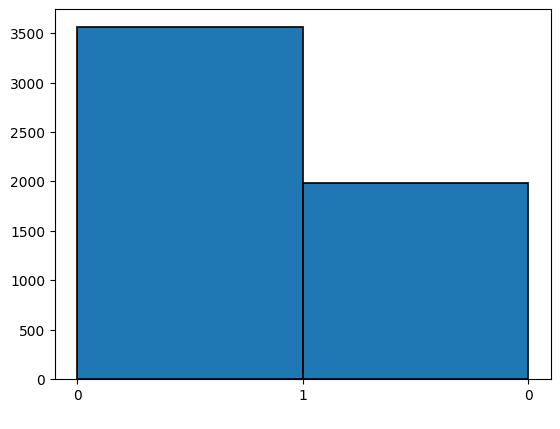

In [5]:
print(Counter(tr_y))
plt.hist(tr_y, bins=2, edgecolor='black', linewidth=1.2) # , color=['red', 'blue'])
plt.show()

In [6]:
tokenizer = TweetTokenizer()
idx = np.random.randint(0, len(tr_txt))
tr_txt[idx]
tokens = tokenizer.tokenize(tr_txt[idx])
print(tokens)

['la', 'salsa', 'verde', 'es', 'mejor', 'que', 'la', 'roja', 'y', 'el', 'que', 'no', 'piense', 'lo', 'mismo', 'que', 'chingue', 'su', 'madre', 'x2', '#mexicandesmotherpalmundial']


In [7]:
corpus_words = []
for txt in tr_txt:
    corpus_words += tokenizer.tokenize(txt)
print(len(set(corpus_words)))

13580


In [8]:
fdist = nltk.FreqDist(corpus_words)
aux = [(fdist[key], key) for key in fdist]
aux.sort()
aux.reverse()
fdist = aux
fdist[:10]

[(3383, 'que'),
 (3357, 'de'),
 (2774, '.'),
 (2629, 'a'),
 (2433, 'la'),
 (2266, 'y'),
 (1824, 'no'),
 (1613, 'me'),
 (1505, '!'),
 (1303, 'el')]

In [9]:
idx_dict = dict()
for i, (freq, word) in enumerate(fdist):
    idx_dict[word] = i
print(idx_dict['que'])

0


In [10]:
def build_bow(tr_txt, V, idx_dict, binary=False):
    X = np.zeros((len(tr_txt), len(V)))
    for i, txt in enumerate(tr_txt):
        tokens = tokenizer.tokenize(txt)
        for token in tokens:
            if token in idx_dict:
                if binary:
                    X[i, idx_dict[token]] = 1
                else:
                    X[i, idx_dict[token]] += 1
    return X

def build_tfidf(tr_txt, V, idx_dict):
    X = build_bow(tr_txt, V, idx_dict, binary=False)
    # TF
    X = X / X.sum(axis=1, keepdims=True)
    # IDF
    df = np.zeros((len(V),))
    for i, txt in enumerate(tr_txt):
        tokens = tokenizer.tokenize(txt)
        for token in tokens:
            if token in idx_dict:
                df[idx_dict[token]] += 1
    idf = np.log(X.shape[0] / ( df + 1e-9) )
    X = X * idf
    return X

bow = build_bow(tr_txt, fdist, idx_dict)
bow.shape

(5544, 13580)

## Bolsa de validacion

Counter({'0\n': 396, '1\n': 219, '0': 1})


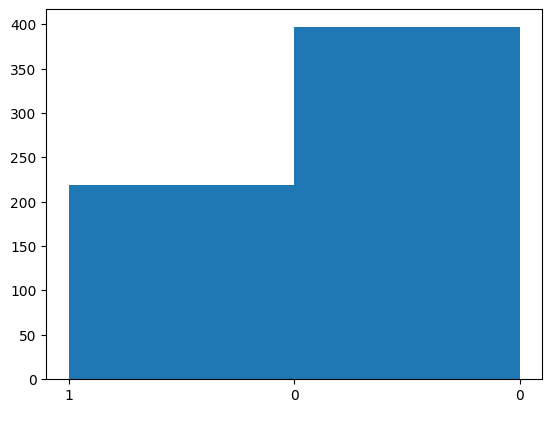

(616, 13580)

In [11]:
val_txt, val_y = get_files(
    'DatasetAgresividad/mex_val.txt',
    'DatasetAgresividad/mex_val_labels.txt'
)

val_txt = np.array(val_txt)
val_y = np.array(val_y)

print(Counter(val_y))
plt.hist(val_y, bins=len(set(val_y))-1)
plt.show()


val_bow = build_bow(val_txt, fdist, idx_dict)
val_bow.shape

# Clasificacion

In [12]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, f1_score

import warnings

In [13]:
bow_non_binary = build_bow(tr_txt, fdist, idx_dict, binary=False)
val_bow_non_binary = build_bow(val_txt, fdist, idx_dict, binary=False)

bow_binary = build_bow(tr_txt, fdist, idx_dict, binary=True)
val_bow_binary = build_bow(val_txt, fdist, idx_dict, binary=True)

tfidf = build_tfidf(tr_txt, fdist, idx_dict)
val_tfidf = build_tfidf(val_txt, fdist, idx_dict)

In [14]:
tr_y = np.array([int(y) for y in tr_y])
val_y = np.array([int(y) for y in val_y])

tr_y[:5], val_y[:5]

(array([0, 0, 0, 1, 0]), array([1, 1, 1, 0, 1]))

In [15]:
def classify(bow, tr_y, val_bow, val_y):

    parameters = {'C' : [0.05, 0.25, 1.0, 2.0]}
    svr = svm.LinearSVC(class_weight='balanced')
    grid = GridSearchCV(svr, parameters, cv=5, scoring='f1_macro')
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        grid.fit(bow, tr_y)
    y_pred = grid.predict(val_bow)

    p, r, f, _ = precision_recall_fscore_support(val_y, y_pred, average="macro")

    return accuracy_score(val_y, y_pred), p, r, f, y_pred

In [16]:
print("Non binary")

acc, p, r, f, non_binary_y_pred = classify(bow_non_binary, tr_y, val_bow_non_binary, val_y)
print(metrics.classification_report(val_y, non_binary_y_pred))

print("Binary")

acc, p, r, f, binary_y_pred = classify(bow_binary, tr_y, val_bow_binary, val_y)
print(metrics.classification_report(val_y, binary_y_pred))

print("TF-IDF")

acc, p, r, f, tf_idf_y_pred = classify(tfidf, tr_y, val_tfidf, val_y)
print(metrics.classification_report(val_y, tf_idf_y_pred))


Non binary
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       397
           1       0.74      0.77      0.75       219

    accuracy                           0.82       616
   macro avg       0.80      0.81      0.81       616
weighted avg       0.82      0.82      0.82       616

Binary
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       397
           1       0.73      0.77      0.75       219

    accuracy                           0.81       616
   macro avg       0.80      0.80      0.80       616
weighted avg       0.82      0.81      0.82       616

TF-IDF
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       397
           1       0.70      0.74      0.72       219

    accuracy                           0.79       616
   macro avg       0.77      0.78      0.78       616
weighted avg       0.80      0.79      0.79      

## Tweets clasificados como no agresivos que si lo eran

In [17]:
for i, (y, y_pred) in enumerate(zip(val_y, binary_y_pred)):
    if y == 1 and y_pred == 0:
        print("Tweet: ", val_txt[i])

Tweet:  así debería ser siempre para que se mueran a la verga

Tweet:  cada día me siento como un perro ovejero tratando de cuidar sus ovejas vale madre pinches rateros póngase a trabajar.😤

Tweet:  ya a cualquier prieto le dicen licenciado peludito tengan madre

Tweet:  su "pura vida" quedó en "pura verga" que se tragaron pinches ticos piojosos

Tweet:  no vayas por el mundo presumiendo tus muchos amores eso es de muy putas.

Tweet:  la que se veía súper mal era demi lovato porque se mamo con el escote y el peinado le quedo feo

Tweet:  ya traigo mi actitud de lunes al cien pinches putos.  me pelan la verga todos

Tweet:  por qué verga mis compañeros de proyecto tienen que ser los más ineptos de todos

Tweet:  una novia intelectual una putona y otra luchona. para que entre las 3 se complementen.

Tweet:  putos locos yo llevo 6 horas y aún no salgo de la segunda isla no mamen.

Tweet:  no me gusta el fútbol pero por putos &gt;:v #noerapenal

Tweet:  no  jajaja ya tiene mucho eso pero t

In [18]:
def get_dor(tr_txt):

    tr_subset = tr_txt
    DoR = np.zeros((tr_subset.shape[1], tr_subset.shape[0]), dtype=np.float64)
    tam_V = DoR.shape[0]

    for doc, i in zip(
        tr_subset,
        range(len(tr_subset))
    ):
        nonzero_positions = np.nonzero(doc)[0]
        tam_v = len(nonzero_positions)
        for pos in nonzero_positions:
            DoR[pos, i] = (1 + np.log10(doc[pos])) * np.log10(tam_V/tam_v)

    return DoR

def get_tcor(tr_txt):

    tr_subset = tr_txt
    TCoR = np.zeros((tr_subset.shape[1], tr_subset.shape[1]), dtype=np.float64)

    for doc, i in zip(
        tr_subset,
        range(len(tr_subset))w
    ):
        nonzero_positions = np.nonzero(doc)[0]
        for pos in nonzero_positions:
            for pos2 in nonzero_positions:
                TCoR[pos, pos2] += 1
    
    return TCoR

TCoR_train = get_tcor(bow_non_binary)
TCoR_val = get_tcor(val_bow_non_binary)

In [19]:
BoW_base = build_bow(tr_txt, fdist, idx_dict)
TCoR_base = get_dor(BoW_base)
TCoR_base = preprocessing.normalize(TCoR_base, norm='l2')

In [20]:
feats = SelectKBest(chi2, k=1000)
feats.fit(BoW_base, tr_y)

SelectKBest(k=1000, score_func=<function chi2 at 0x000001ED3D16FF70>)

In [21]:
best = feats.get_support(indices=True)
len(best)

1000

In [22]:
dict_ind_inverse = dict()

for w in idx_dict:
    dict_ind_inverse[idx_dict[w]] = w

In [23]:
t_words = [dict_ind_inverse[index] for index in best]
t_words

['de',
 'a',
 'la',
 'me',
 '!',
 'el',
 '@usuario',
 'en',
 'verga',
 'se',
 'putas',
 'los',
 'putos',
 'mi',
 'te',
 '"',
 'las',
 'como',
 'loca',
 'su',
 'tu',
 'una',
 'pero',
 '😂',
 'del',
 'yo',
 'pinche',
 'cuando',
 'puta',
 'todos',
 ':',
 'son',
 'estoy',
 '¿',
 'les',
 'hdp',
 'porque',
 'sus',
 'joto',
 'esta',
 'está',
 '…',
 'q',
 'soy',
 'vale',
 'puto',
 'pinches',
 'mis',
 'quiero',
 'luchona',
 'eres',
 'vida',
 'mierda',
 'siempre',
 '️',
 '¡',
 'ese',
 'tiene',
 'hoy',
 'tengo',
 'día',
 'maricon',
 'hijos',
 'pendejo',
 '-',
 'tienen',
 ')',
 'hijo',
 'esos',
 '(',
 '😭',
 'van',
 'tus',
 'alguien',
 '”',
 '“',
 '..',
 'mamá',
 'pendeja',
 'sí',
 '😍',
 'madres',
 'dos',
 'vas',
 'sé',
 'méxico',
 '❤',
 'amor',
 'algo',
 'están',
 'también',
 'días',
 'puedo',
 'culo',
 'mundial',
 'mañana',
 'años',
 '2',
 'mamar',
 'pendejos',
 'chingas',
 'alv',
 'menos',
 'cosas',
 'chingar',
 'mucho',
 'casa',
 'putita',
 'digo',
 'mil',
 'ojalá',
 'estaba',
 'deja',
 'd',
 'h

In [24]:
target_matrix = np.array([
    TCoR_base[
        idx_dict[word]
    ]
    for word in t_words
])

target_matrix.shape

(1000, 5544)

In [25]:
from tsne import tsne

In [26]:
reduced_matrix = tsne(target_matrix, 2) 

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.097910
Iteration 10: error is 17.581969
Iteration 20: error is 17.318962
Iteration 30: error is 16.999522
Iteration 40: error is 17.091802
Iteration 50: error is 17.030264
Iteration 60: error is 17.039128
Iteration 70: error is 17.033300
Iteration 80: error is 17.030623
Iteration 90: error is 17.029136
Iteration 100: error is 17.014828
Iteration 110: error is 2.040949
Iteration 120: error is 1.549950
Iteration 130: error is 1.355471
Iteration 140: error is 1.243553
Iteration 150: error is 1.172295
Iteration 160: error is 1.125700
Iteration 170: error is 1.092071
Iteration 180: error is 1.065251
Iteration 190: error is 1.043957
Iteration 200: error is 1.026218
Iteration 210: error is 1.011806
Iteration 220: error is 1.000281
Iteration 230: error is 0.990625
Iteration 240: error is 0.982404
Iteration 250: error is

c:\Users\David Arcos\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  func(*args, **kwargs)
c:\Users\David Arcos\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  func(*args, **kwargs)
c:\Users\David Arcos\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  func(*args, **kwargs)
c:\Users\David Arcos\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from current font.
  func(*args, **kwargs)
c:\Users\David Arcos\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 129316 (\N{DROOLING FACE}) missing f

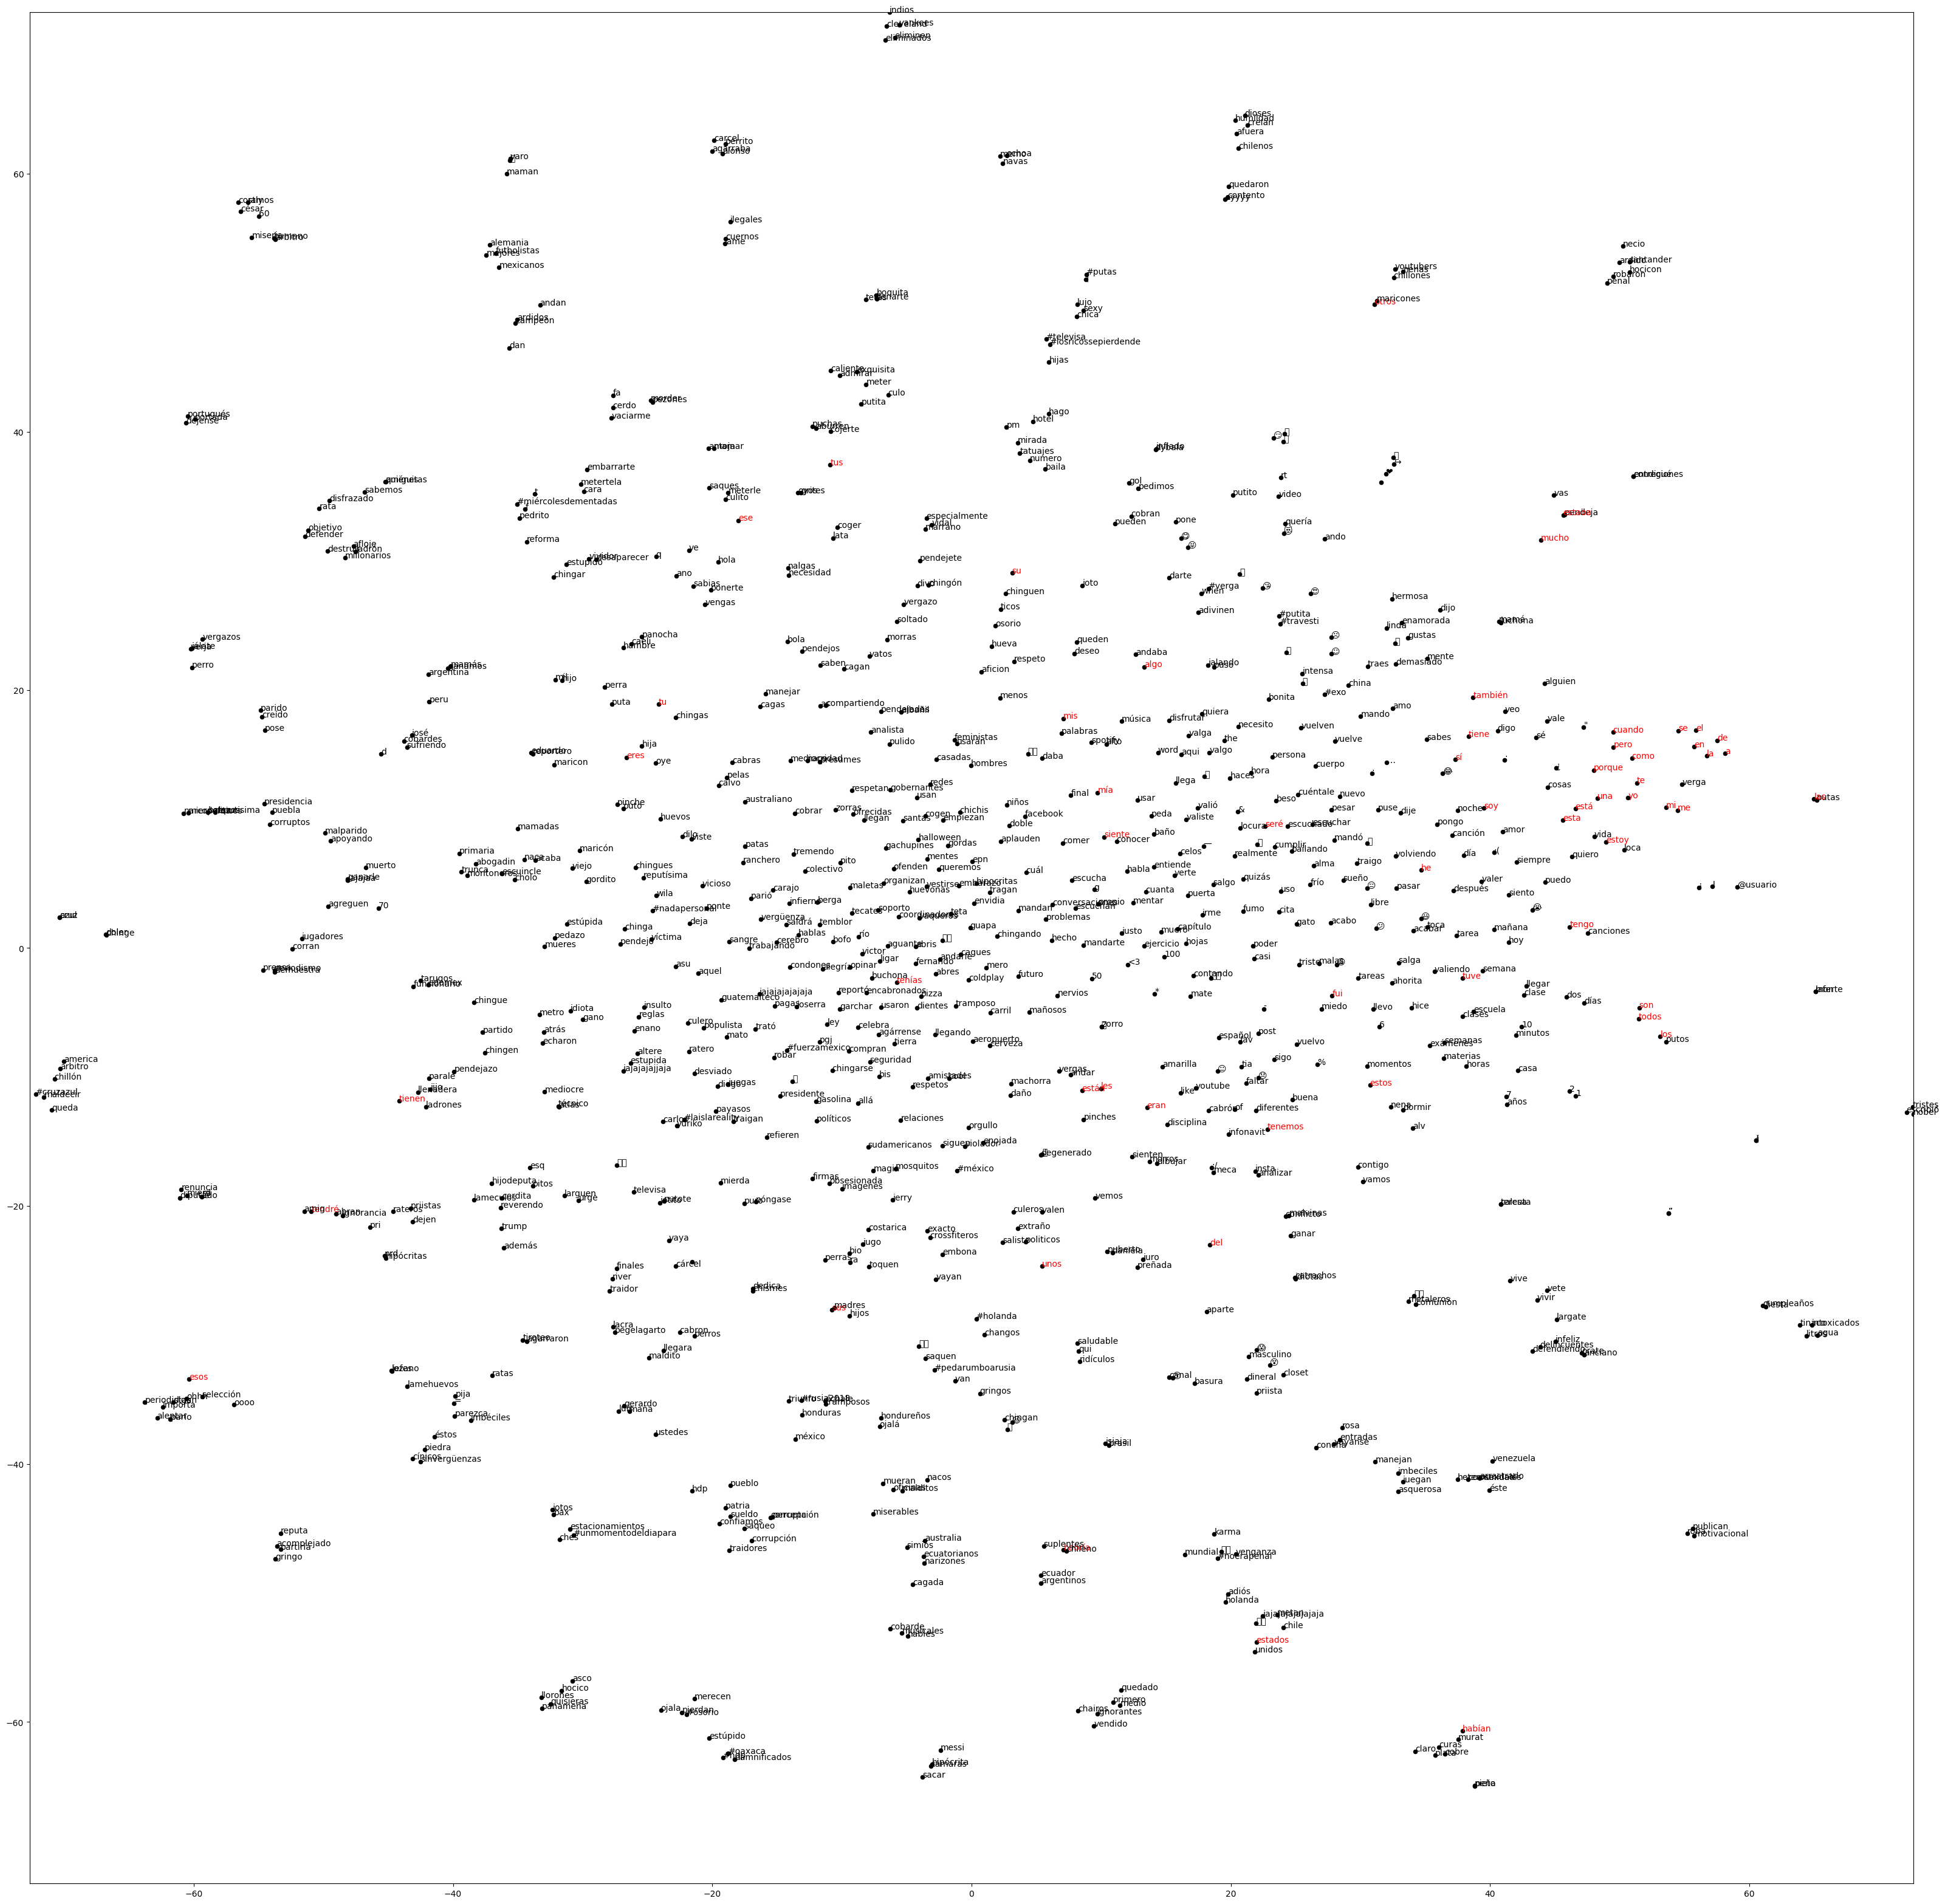

In [27]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords

sw = set(stopwords.words("spanish"))

plt.figure(figsize=(40, 40), dpi=100); 
plt.xlim((-max_x,max_x)); 
plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color="black");

for idx, word in enumerate(t_words[:]):
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]  
    if word in sw:
        plt.annotate(word, (x,y), color="red")
    else: 
        plt.annotate(word, (x,y), color="black")

## Conclusion

En conclusion, DoR y TCoR son muy parecidos, pues ambos son matrices de representacion de palabras. Cuando tenemos muchas palabras que documentos TCoR puede ser mas complejo en memoria, puesto que la matriz es una matriz cuadrada de la dimension de el numero de los terminos. Es por eso que si tenemos una distribucion pequena de palabras, quizas seria conveniente usar TCoR, pero si el numero de terminos es muy grande, estariamos sacrificando muchos recursos computacionales. Sabiendo esto, TCoR a su vez puede ser una mejor idea ya que en lugar de representar los terminos contra los documentos, y penalizando en base a sus apariciones y contextos, en este caso hacemos una comparacion termino a termino, por lo que conservamos mejor el contexto entre palabras, y obtenemos una distribucion mas cercana entre palabras que estan correlacionadas, sin importarnos realmente en cuantos documentos aparecen.